# Imports

In [1]:
from pyathena import connect
import pandas as pd
import numpy as np

from pathlib import Path 
current_path = Path().resolve()

RAW_PATH = current_path.parent / 'data' / 'raw'
OUTPUT_PATH = current_path.parent / 'data' / 'output'

%matplotlib inline

# Connections

In [2]:
conn = connect(s3_staging_dir='s3://athena-fgv/staggin',
               region_name='us-east-2')

# OSM Data

https://taginfo.openstreetmap.org/keys

In [3]:
sample = pd.read_sql_query('SELECT * FROM "osm"."california_district_3" limit 10;', conn)

In [4]:
sample.head(4)

,id,type,tags,lat,lon,nds,members,changeset,timestamp,uid,user,version
0,1030979464,node,{},39.636424,-120.012501,[],[],6605481,2010-12-10 15:31:39,55774,nmixter,1
1,1030979570,node,{},39.626327,-120.015171,[],[],6605536,2010-12-10 15:31:42,55774,nmixter,1
2,1030979605,node,{},39.634838,-119.963224,[],[],6605481,2010-12-10 15:31:42,55774,nmixter,1
3,1030979617,node,{},39.684711,-119.992431,[],[],6605481,2010-12-10 15:31:42,55774,nmixter,1


In [12]:
update_log = pd.read_sql_query("""SELECT CAST(timestamp as date) as date,
count(*) as counta
FROM "osm"."california_district_3" 
GROUP BY CAST(timestamp as date)""", conn)

In [13]:
update_log.head(1)

,date,counta
0,2016-10-16,690


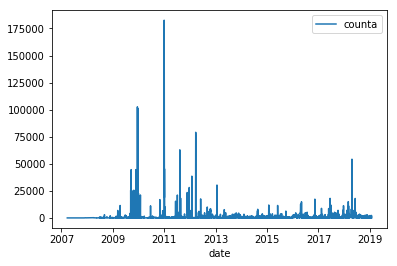

In [17]:
update_log.sort_values(by='date').plot(x='date')

# ADT data

In [5]:
adt = pd.read_parquet(RAW_PATH / 'pems_waze_features12.parquet')

In [6]:
adt = adt[['station', 'total_flow']].drop_duplicates().groupby('station').sum().sort_values(by='total_flow')

In [7]:
adt.head()

,total_flow
station,
312692,0.0
314621,0.0
314981,0.0
314618,0.0
318577,0.0


In [8]:
# adt = adt[adt['total_flow'] > 0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113b25ef0>]],
      dtype=object)

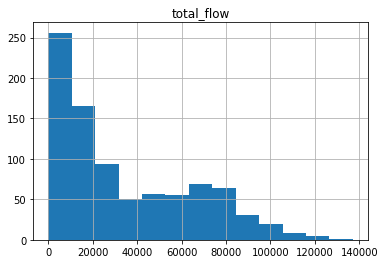

In [9]:
adt[adt['total_flow'] > 0].hist(bins='fd')

# Features

The intent of OSM features is to get surrounding characteristics:

0. Overall
1. Urban x Rural
2. Residential x Comercial x Industrial
3. Places of Interest (POIs)
4. Recreational activity 

In [94]:
query = """
SELECT 
  CAST(sensor_id AS BIGINT) as sensor_id,
  t.neigh_level,
  -- general features
  COUNT(*) as general_counta,
  COUNT (DISTINCT s.osm_id) as node_counta,
  COUNT (DISTINCT s.info) as info_counta,
  -- urban x rural
  SUM(CASE WHEN info = 'natural' THEN 1 ELSE 0 END) as natural_counta,
  SUM(CASE WHEN info = 'place' THEN 1 ELSE 0 END) as place_counta, -- place tags are mostly for small localities
  SUM(CASE WHEN info = 'parking' THEN 1 ELSE 0 END) as parking_counta,   
  SUM(CASE WHEN info = 'addr:street' THEN 1 ELSE 0 END) as addr_street_counta,   
  SUM(CASE WHEN info = 'addr:housenumber' THEN 1 ELSE 0 END) as addr_housenumber_counta, 
  -- places of interest
  SUM(CASE WHEN info = 'amenity' THEN 1 ELSE 0 END) as amenity_counta,
  SUM(CASE WHEN info = 'school' THEN 1 ELSE 0 END) as school_counta,
  SUM(CASE WHEN info = 'restaurant' THEN 1 ELSE 0 END) as restaurant_counta,
  SUM(CASE WHEN info = 'place_of_worship' THEN 1 ELSE 0 END) as place_of_worship_counta,
  SUM(CASE WHEN info = 'shop' THEN 1 ELSE 0 END) as shop_counta
FROM "osm_pems"."osm_pems_ids" t
JOIN osm.california_district_3_open s
ON t.osm_id = s.osm_id
GROUP BY sensor_id,  t.neigh_level
"""

In [95]:
features = pd.read_sql_query(query, con=conn)

In [96]:
features.head()

,sensor_id,neigh_level,general_counta,node_counta,info_counta,natural_counta,place_counta,parking_counta,addr_street_counta,addr_housenumber_counta,amenity_counta,school_counta,restaurant_counta,place_of_worship_counta,shop_counta
0,314204,4,28026,9485,2639,14,3,6,1076,2039,459,20,16,24,85
1,320037,6,64230,17285,4562,8,3,20,3939,3768,602,13,18,13,71
2,318333,6,142526,16280,6706,76,11,3,11609,11601,575,45,124,62,152
3,316124,4,9492,1988,1046,0,6,1,89,89,258,34,14,69,67
4,317143,3,1226,391,157,58,0,1,17,17,20,0,1,4,4


In [97]:
dfall = features.merge(adt, left_on='sensor_id', right_index=True)

# Simple Exploratory Analysis

## Introducing categories

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a22f080>]],
      dtype=object)

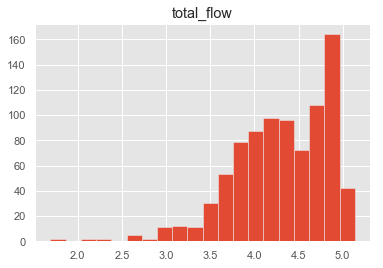

In [296]:
adt[adt['total_flow'] > 0].apply(np.log10).hist(bins='fd')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118f61c18>]],
      dtype=object)

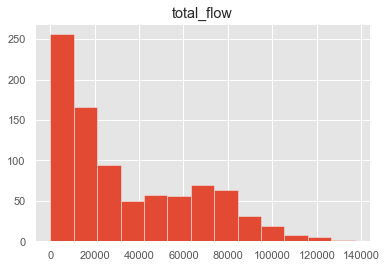

In [295]:
adt[adt['total_flow'] > 0].hist(bins='fd')

In [99]:
dfall['total_flow_log'] = dfall['total_flow'].apply(np.log10)

In [309]:
bins = pd.IntervalIndex.from_tuples([(0, 20000), (20000, 80000), (80000, 1400000)])
dfall['cats'] = pd.cut(dfall['total_flow'], bins)

In [310]:
dfall = dfall[dfall['total_flow']>0]

In [311]:
dfall.reset_index().drop_duplicates('sensor_id').groupby('cats').count()['sensor_id']

cats
(0, 20000]          411
(20000, 80000]      384
(80000, 1400000]     81
Name: sensor_id, dtype: int64

## Generict Dist Plot

In [312]:
features = [f for f in dfall.columns if f not in ['sensor_id', 'neigh_level', 'total_flow', 'total_flow_log', 'cats']]
cats = dfall['cats'].unique()

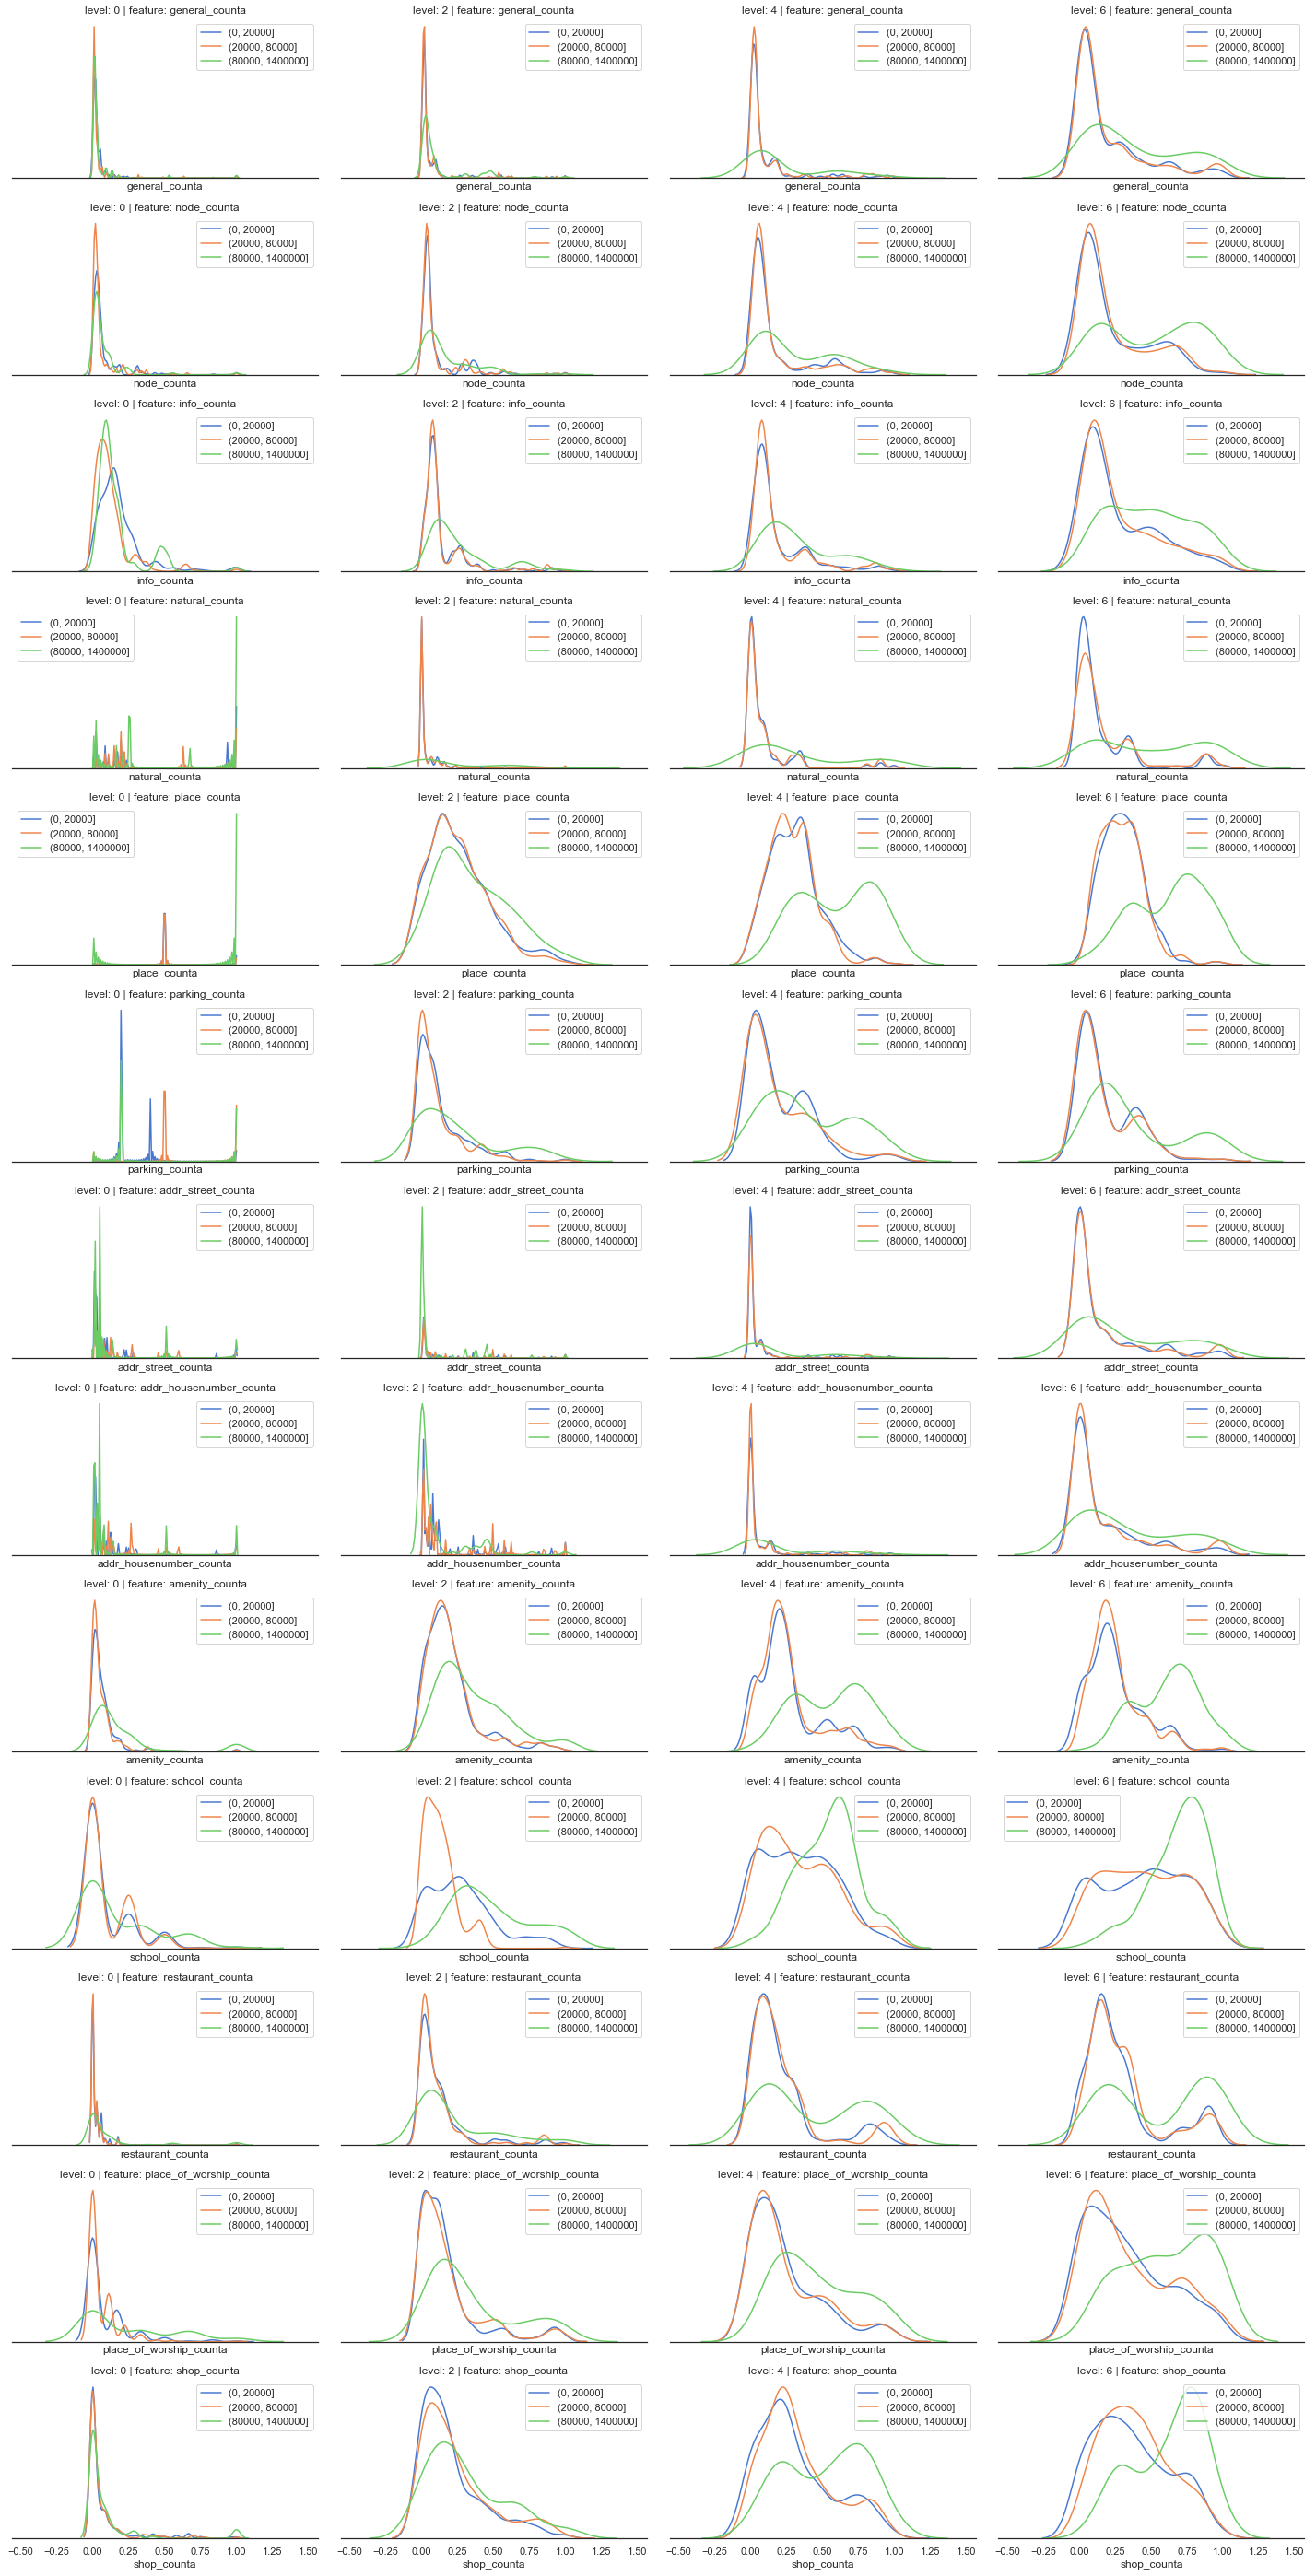

In [313]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(len(features), 4, figsize=(20, len(features) * 3), sharex=True)
sns.despine(left=True)

for i, level in enumerate([0, 2, 4, 6]):
    df_level = dfall[dfall['neigh_level'] == level]
    for plot_number in range(len(features)):
        axes[plot_number, i].set_title(f'level: {level} | feature: {features[plot_number]}' )
        for cat in cats:
            df_plot = df_level[df_level['cats'] == cat]
            sns.distplot((df_plot[features[plot_number]] 
                          / (df_plot[features[plot_number]].max() 
                             + 0.000001)),
                         kde=True, 
                         hist=False, 
                         label=cat,
                         ax=axes[plot_number, i])


plt.setp(axes, yticks=[])
plt.tight_layout()

# Prepare Database

In [315]:
#dfall = dfall.set_index('sensor_id')

In [316]:
df_features = pd.concat([dfall[dfall['neigh_level'] == level][features].rename(columns={f: '_'.join([f, str(level)]) for f in features}) for level in [0, 2, 4, 6]], 1)

In [317]:
df_features_colums = df_features.columns
df_features_index = df_features.index

In [318]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_features = scaler.fit_transform(df_features)

In [319]:
df_features = pd.DataFrame(df_features, columns=df_features_colums, index=df_features_index)

In [320]:
X = df_features
y = dfall['cats'].apply(str)

In [321]:
X = X.fillna(0)

In [322]:
y = dfall.reset_index().drop_duplicates(subset=['sensor_id']).set_index('sensor_id')['cats'].apply(str)

# Feature Selection

## Univariate Selection

https://christophm.github.io/interpretable-ml-book/feature-importance.html

In [324]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=len(X.columns))
fit = bestfeatures.fit(X.values,y.values)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(len(X.columns),'Score')) 

                        Specs     Score
12              shop_counta_0  2.240724
6        addr_street_counta_0  1.837007
24  place_of_worship_counta_2  1.742693
29           natural_counta_4  1.575779
7   addr_housenumber_counta_0  1.409990
0            general_counta_0  1.073474
4              place_counta_0  1.039783
42           natural_counta_6  1.015286
2               info_counta_0  1.005540
10        restaurant_counta_0  0.926478
1               node_counta_0  0.822833
23        restaurant_counta_2  0.693838
31           parking_counta_4  0.584972
8            amenity_counta_0  0.552158
37  place_of_worship_counta_4  0.504229
20  addr_housenumber_counta_2  0.495245
19       addr_street_counta_2  0.493398
32       addr_street_counta_4  0.464190
33  addr_housenumber_counta_4  0.463907
14              node_counta_2  0.442279
36        restaurant_counta_4  0.428481
25              shop_counta_2  0.420643
17             place_counta_2  0.400448
27              node_counta_4  0.395353


## Feature Importance

[0.03 0.01 0.03 0.01 0.01 0.01 0.02 0.02 0.03 0.02 0.01 0.01 0.01 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.02 0.02 0.02 0.02 0.02 0.01 0.02
 0.01 0.02 0.02 0.02 0.03 0.01 0.02 0.02 0.02 0.03 0.03 0.02 0.01 0.01
 0.02 0.03 0.02 0.02 0.02 0.02 0.03 0.02 0.03 0.02]


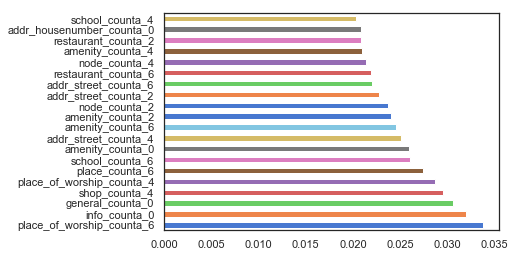

In [325]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X.values,y.values)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## Confusion Matrix

In [326]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# Model Agnostic Feature Importance

https://github.com/datascienceinc/Skater/blob/master/examples/ensemble_model.ipynb

In [327]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
# Reference for customizing matplotlib: https://matplotlib.org/users/style_sheets.html
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
clf4 = ExtraTreesClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('et', clf4)], voting='soft')
eclf = eclf.fit(X_train, y_train.values)

clf1 = clf1.fit(X_train, y_train.values)
clf2 = clf2.fit(X_train, y_train.values)
clf3 = clf3.fit(X_train, y_train.values)
clf4 = clf4.fit(X_train, y_train.values)

models = {'LogisticRegression':clf1, 
          'RandomForest':clf2, 
          'GaussianNB':clf3, 
          'ExtraTrees':clf4,
          'ensemble':eclf}

In [331]:
y_train.value_counts()

(0, 20000]          330
(20000, 80000]      308
(80000, 1400000]     62
Name: cats, dtype: int64

In [332]:
y_test.value_counts()

(0, 20000]          81
(20000, 80000]      76
(80000, 1400000]    19
Name: cats, dtype: int64

2019-03-16 18:13:42,051 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[52/52] features ████████████████████ Time elapsed: 4 seconds

2019-03-16 18:13:46,967 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[52/52] features ████████████████████ Time elapsed: 4 seconds

2019-03-16 18:13:52,025 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[52/52] features ████████████████████ Time elapsed: 4 seconds

2019-03-16 18:13:56,873 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[52/52] features ████████████████████ Time elapsed: 4 seconds

2019-03-16 18:14:01,982 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[52/52] features ████████████████████ Time elapsed: 6 seconds

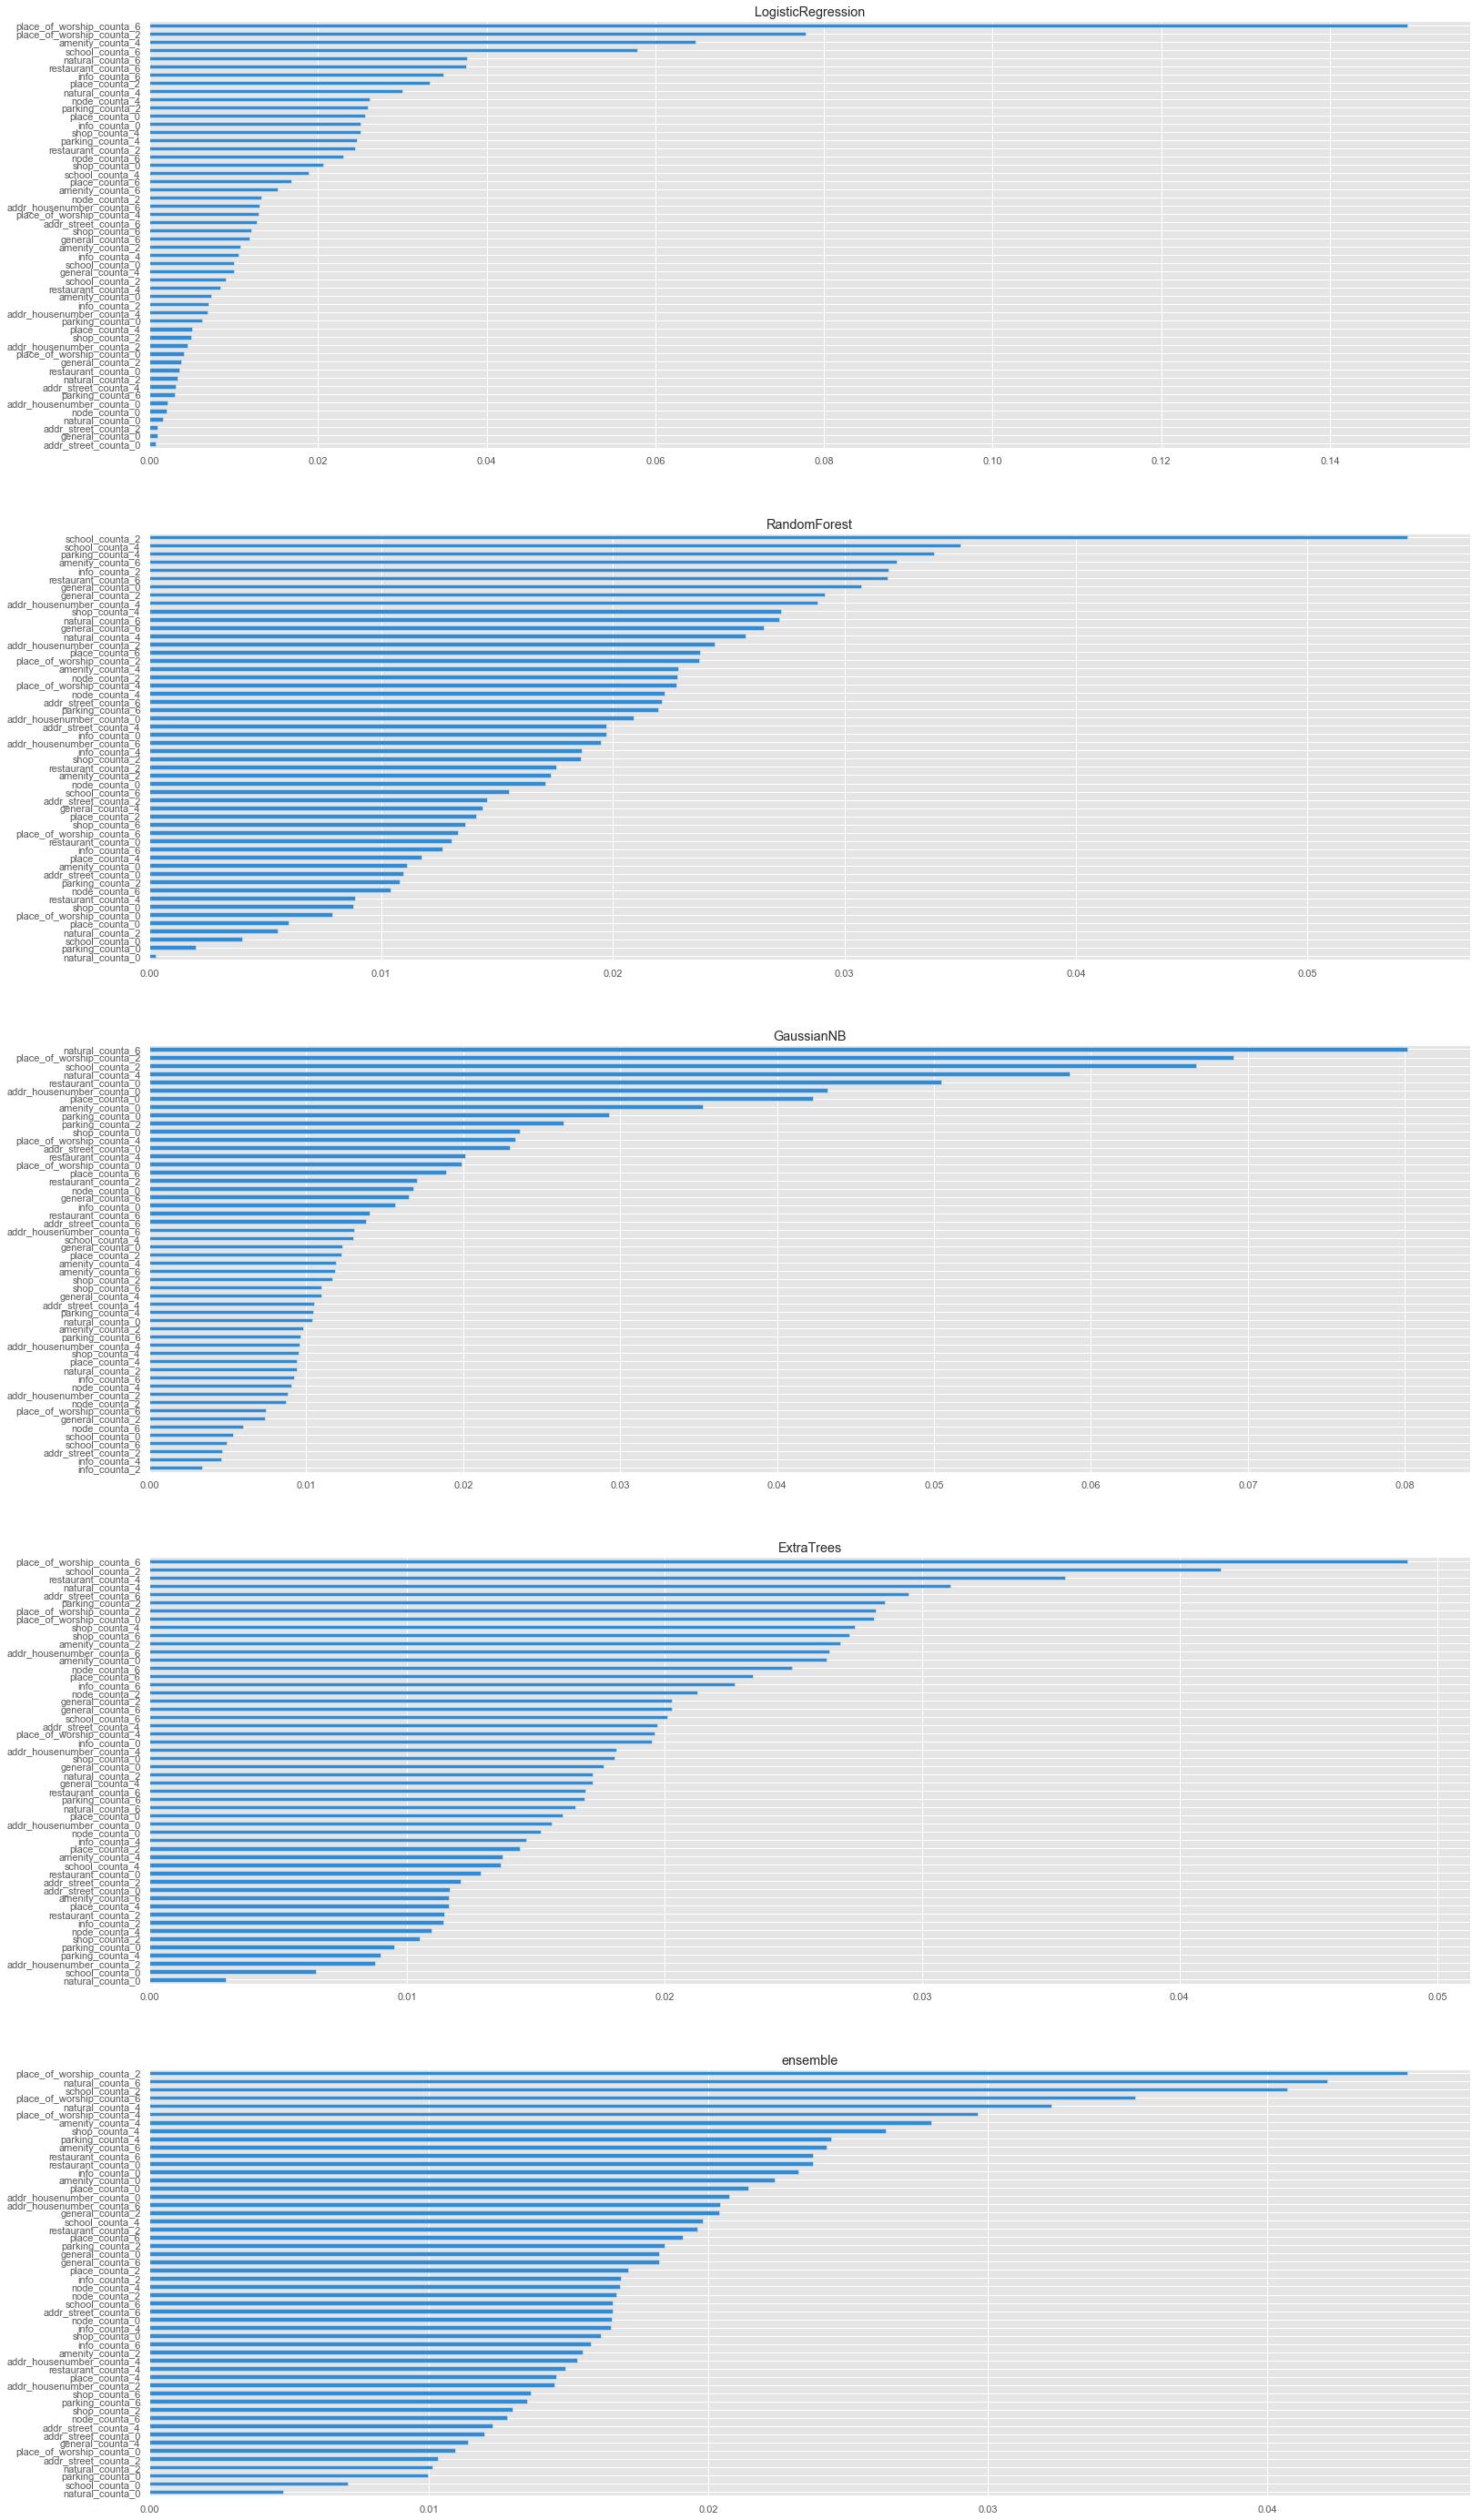

In [333]:
# Ensemble Classifier does not have feature importance enabled by default
f, axes = plt.subplots(len(models), 1, figsize = (16, len(models)*20))

ax_dict = {
    'LogisticRegression':axes[0], 
    'RandomForest':axes[1], 
    'GaussianNB':axes[2], 
    'ExtraTrees':axes[3],
    'ensemble':axes[4]
}

interpreter = Interpretation(X_test.values, feature_names=list(df_features_colums))

for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_test)
    ax = ax_dict[model_key]
    interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=True, ax=ax)
    ax.set_title(model_key)

In [334]:
# Before interpreting, lets check on the accuracy of all the models
from sklearn.metrics import f1_score
for model_key in models:
        print("Model Type: {0} -> F1 Score: {1}".
              format(model_key, f1_score(y_test.values, models[model_key].predict(X_test.values), average='micro')))


Model Type: LogisticRegression -> F1 Score: 0.5170454545454546
Model Type: RandomForest -> F1 Score: 0.4375
Model Type: GaussianNB -> F1 Score: 0.26136363636363635
Model Type: ExtraTrees -> F1 Score: 0.4375
Model Type: ensemble -> F1 Score: 0.4318181818181818


Confusion matrix, without normalization
[[51 30  0]
 [36 40  0]
 [14  5  0]]


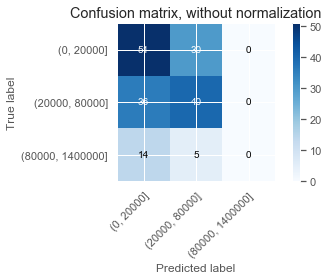

In [341]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, models['LogisticRegression'].predict(X_test.values), classes=list(map(str, cats)),
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [258]:
unique_labels(y_test, models[model_key].predict(X_test.values))

array(['(0, 3]', '(3, 5]', '(5, 6]'], dtype='<U6')

In [252]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

In [259]:
class_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

['(3, 5]', '(5, 6]', '(0, 3]']

In [162]:
pickle.dump(X, open(OUTPUT_PATH / 'X_v1.p', 'wb'))
pickle.dump(Y, open(OUTPUT_PATH / 'Y_v1.p', 'wb'))